In [412]:
import numpy as np
import argparse, sys, os, cv2, time
from PIL import Image

sys.path.append("/scratch/cvlab/home/afan/projects/2DImageTransform")
from datasets.dtu_yao import MVSDataset

from einops import (rearrange, reduce, repeat)

import time

import matplotlib.pyplot as plt
%matplotlib inline


from models import *
import torch
from utils import *
from torch.utils.data import DataLoader

import torch.nn.functional as F
import cv2

import gc
gc.collect()
torch.cuda.empty_cache()

In [413]:
def visualize_depth(depth, mask=None, depth_min=None, depth_max=None, direct=False):
    """Visualize the depth map with colormap.
       Rescales the values so that depth_min and depth_max map to 0 and 1,
       respectively.
    """
    if not direct:
        depth = 1.0 / (depth + 1e-6)
    invalid_mask = np.logical_or(np.isnan(depth), np.logical_not(np.isfinite(depth)))
    if mask is not None:
        invalid_mask += np.logical_not(mask)
    if depth_min is None:
        depth_min = np.percentile(depth[np.logical_not(invalid_mask)], 5)
    if depth_max is None:
        depth_max = np.percentile(depth[np.logical_not(invalid_mask)], 95)
    depth[depth < depth_min] = depth_min
    depth[depth > depth_max] = depth_max
    depth[invalid_mask] = depth_max

    depth_scaled = (depth - depth_min) / (depth_max - depth_min)
    depth_scaled_uint8 = np.uint8(depth_scaled * 255)
    depth_color = cv2.applyColorMap(depth_scaled_uint8, cv2.COLORMAP_MAGMA)
    depth_color[invalid_mask, :] = 0

    return depth_color

In [414]:
datapath = "/scratch/cvlab/datasets/dataset_afan/VolRecon/DTU_training"
listfile = "/scratch/cvlab/home/afan/projects/2DImageTransform/lists/dtu/train.txt"
num_view = 2

train_dataset = MVSDataset(datapath, listfile, "train", num_view)

mvsdataset kwargs {}
dataset train metas: 27097


In [415]:
data = train_dataset.__getitem__(34)

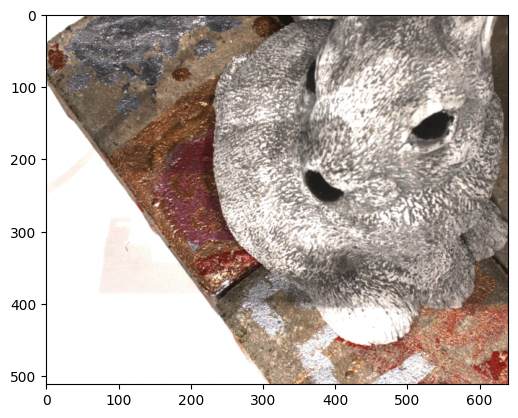

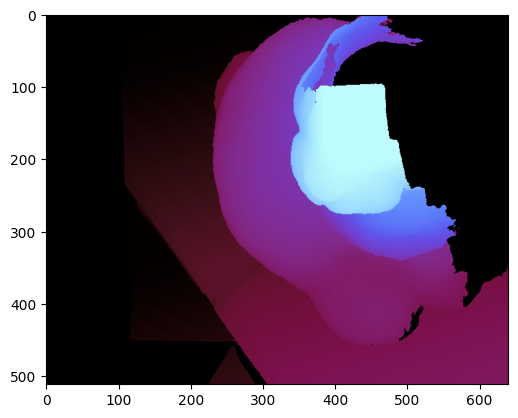

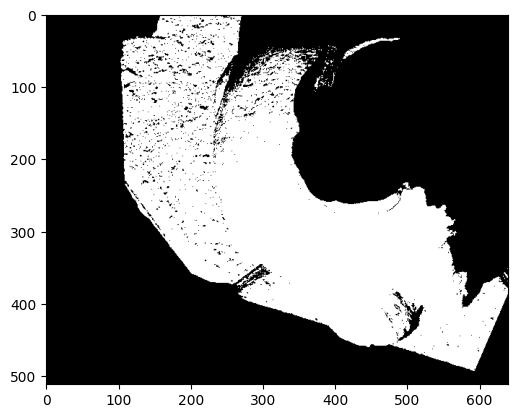

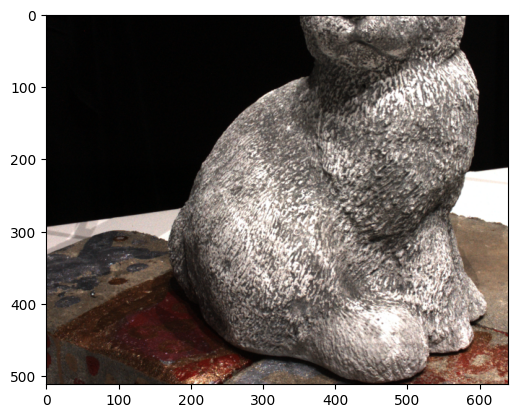

In [416]:
images = data['imgs']
proj_matrices = data['proj_matrices']
depth_maps = data['depth_map']
masks = data['masks']
geo_masks = data['geo_masks']

reference_image = rearrange(images[0], "C H W -> H W C")
reference_image = np.uint8(255 * reference_image)
plt.figure()
plt.imshow(reference_image)

reference_depth = depth_maps

color_map = visualize_depth(reference_depth, mask=masks[0])
plt.figure()
plt.imshow(color_map)

src = 1

geo_mask = geo_masks[src-1]
geo_mask = geo_mask.astype('float') * 255
plt.figure()
plt.imshow(geo_mask, cmap='gray', vmin=0, vmax=255)


source_image = rearrange(images[src], "C H W -> H W C")
source_image = np.uint8(255 * source_image)
plt.figure()
plt.imshow(source_image)

In [417]:
print(images.shape)
print(depth_maps.shape)
print(geo_masks.shape)


_, _, H, W = images.shape
scale = np.array([W / 512, H / 512])[None, :, None]

images = torch.tensor(images)

print(images.shape)
test_images = F.interpolate(images, size=(200, 300), mode="bilinear")
print(test_images.shape)

images = F.interpolate(images, size=(512, 512), mode="bilinear")

depth_maps = torch.tensor(depth_maps)[None, None]
depth_maps = F.interpolate(depth_maps, size=(512, 512), mode="bilinear")

geo_masks = torch.tensor(geo_masks.astype("float"))[None]
geo_masks = F.interpolate(geo_masks, size=(512, 512), mode="bilinear")
geo_masks = geo_masks > 0.5

proj_matrices[:, 1, :2, :] = proj_matrices[:, 1, :2, :] / scale



(2, 3, 512, 640)
(512, 640)
(1, 512, 640)
torch.Size([2, 3, 512, 640])
torch.Size([2, 3, 200, 300])


In [418]:
images = images.numpy()
depth_maps = depth_maps[0,0].numpy()
geo_masks = geo_masks[0,0].numpy()

pool = np.asarray(geo_masks).nonzero()
num_sample = 3
sample = np.random.choice(range(len(pool[0])), num_sample)
pixel_sample = np.concatenate((pool[1][sample][None, :], pool[0][sample][None, :]), axis=0)
pixel_sample = np.concatenate((pixel_sample, np.ones((1, num_sample))), axis=0)
print(pixel_sample)
depth_sample = depth_maps[(pool[0][sample], pool[1][sample])]
print(depth_sample)

[[201. 129. 247.]
 [  7.  70. 218.]
 [  1.   1.   1.]]
[786.5845 776.8296 595.6917]


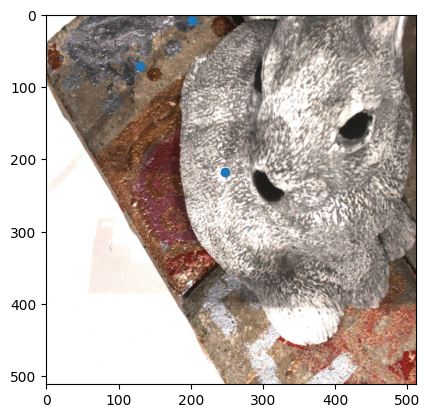

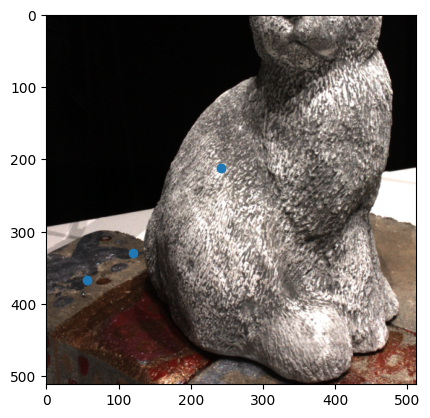

In [419]:
extrinsics = proj_matrices[:, 0, ...]
intrinsics = proj_matrices[:, 1, ...]

plt.figure()
reference_image = rearrange(images[0], "C H W -> H W C")
plt.imshow(reference_image)
plt.scatter(pixel_sample[0], pixel_sample[1])

src_views = [1]
for idx in src_views:
    K0 = intrinsics[0, :3, :3]
    K = intrinsics[idx, :3, :3]
    relative_extrinsics =  extrinsics[idx] @ np.linalg.inv(extrinsics[0])
    R = relative_extrinsics[:3, :3]
    t = relative_extrinsics[:3, 3]
    t = t[:, None]

    p_prime = K @ (R @ (np.linalg.inv(K0) @ pixel_sample * depth_sample[None, :]) + t)
    p_prime = p_prime / p_prime[2]

    plt.figure()
    imageB = rearrange(images[idx], "C H W -> H W C")
    plt.imshow(imageB)
    plt.scatter(p_prime[0], p_prime[1])
    plt.show()

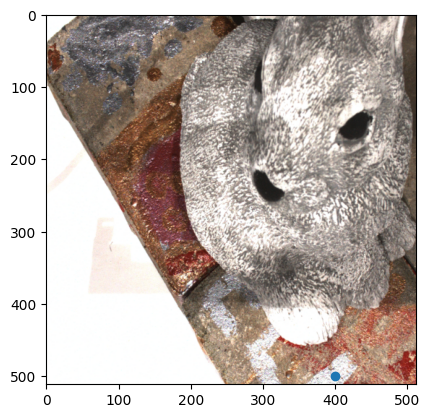

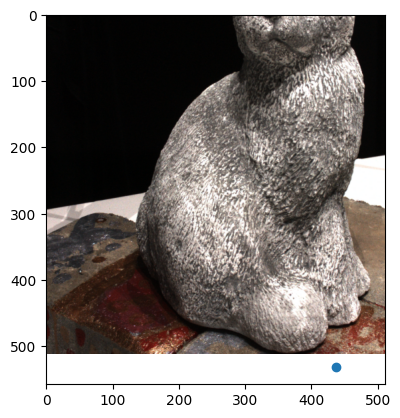

In [420]:

extrinsics = proj_matrices[:, 0, ...]
intrinsics = proj_matrices[:, 1, ...]

w = 400
h = 500
p = np.array([w, h, 1])
p = p[:, None]


plt.figure()
reference_image = rearrange(images[0], "C H W -> H W C")
plt.imshow(reference_image)
plt.scatter(w, h)

src_views = [1]
for idx in src_views:
    K0 = intrinsics[0, :3, :3]
    K = intrinsics[idx, :3, :3]
    relative_extrinsics =  extrinsics[idx] @ np.linalg.inv(extrinsics[0])
    R = relative_extrinsics[:3, :3]
    t = relative_extrinsics[:3, 3]
    t = t[:, None]

    d = depth_maps[h, w]
    p_prime = K @ (R @ (np.linalg.inv(K0) @ p * d) + t)
    p_prime = p_prime / p_prime[2]

    plt.figure()
    imageB = rearrange(images[idx], "C H W -> H W C")
    plt.imshow(imageB)
    plt.scatter(p_prime[0], p_prime[1])
    plt.show()